<h1 style="text-align:center;">
    Tutorial on how to preprocess data for NLP tasks 📑🔥
</h1>

<p style="font-size: 16px">
    In this tutorial we will create a multi-purpose NLP preprocessing pipeline that may be useful for other problems as well. I like to think of NLP tasks as a <b>X-step process</b>. One of the most complicated aspects of dealing with text data is that you need to preprocess your data thoroughly <b>before</b> doing any statistics.
</p>
<p style="font-size: 16px">
    This is because most of the statistics depend on character/word/sentence counts, and it's impossible to determine those accurately without removing possible problems like links, mentions and other invonveniences.
</p>

<p style="font-size: 16px">
    First and foremost, let's import some of the libraries we are going to be using during this process. Most of them are standard for this tasks, so it's god to get familiar with them!
</p>

<h2>
    Imports
</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import typing
from collections.abc import Iterable

import gc

from IPython import display

<h1>
    Process overview
    </h1>

<p style="font-size: 16px">
    Below you can find the general guide of how to preprocess data on NLP tasks. I'm not including the "reading" of the data even though it's relevant, because it's not something that is specific to NLP tasks. So imagine the first "real" step or step zero is actually reading the data.
</p>
    
<ol style="font-size: 14px">
  <li>First, <b>explore the data carefully</b>: to get an overview of what we might expect. Here we check if the data contains links, mentions, etc. We have to know what we are going to have to deal with. Remember we generally want to remove these special cases, as ML models cannot learn from single occurences and they will probably reduce model performance.</li>
    <li><b>Then we start the preprocesing stage</b>: Once we know what elements we want to preprocess in our data, we want to remove those that may affect the performance of the model. This is where we start preprocessing each line of text. <b>Stopwords are also removed at this stage</b>.</li>
  <li>Third, we <b>apply general statistics</b>. Once the text is clean, we want a general understanding of the behavior of our data. Here we might apply character counts, word counts and sentence counts. At this point, it may be interesting to check if the counts are different (on average) for the different values of the target variable.</li>
  <li>Then, <b>building the vocabulary and word frequency</b>. We want to understand which are the most frequent and relevant words in our data. There is a comment on word clouds in this section that may be important to read!</li>
  <li>We then <b>implement the "out-of-vocabulary" token (#OOV)</b>. This token represents words that don't have enough relevance in the text to be fed to the ML model. There are other tokens that may be interesting to include. For example, most people remove numbers and percentages, but I've found that changing them for the #PERCENT token can yield good results.</li>
  <li>Finally, we <b>vectorize the data</b>. Strings are not consumable by ML models, so we need to convert our data to a vector that the model can understand. There are a lot of approaches for this task, here we will use Bag-of-Words (BoW) and TF-IDF transformations.</li>
</ol>

<img src="https://cdn-images-1.medium.com/max/1500/1*e-alZf1lGPNGXW81v3JC_A.jpeg" width="400px" align="center">

<h2>
    Reading the data
    </h2>

In [2]:
df_base = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
df_base.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
df_base.shape

(1804874, 45)

<h2>Taking a sample of the entire Dataset</h2>

<p style="font-size: 16px">
    If you notice the size of the Dataset, it's a very large file to keep in memory. So we are going to remove the dataset from memory, garbage collect, and use a subsample on which we will perform all of our analytics. 
    </p>
    
<p style="font-size: 16px">
    There's also the imbalance problem. The dataset is heavily imbalanced (most comments are not toxic) so we need to rebalance our dataset. We build a function to do so and extract a balanced sample.
    </p>

In [4]:
def binarize_dataframe(
    df: pd.DataFrame, feature_to_binarize: str, threshold: float = 0.5
) -> pd.DataFrame:
    """Function to turn a continuous variable into a discrete, binary variable.
    
    :param df: DataFrame you want to binarize
    :type df: pd.DataFrame
    :param feature_to_binarize: Name of the column where the variable is.
    :type feature_to_binarize: str
    :param threshold: Value on which you want to rebalance. Values higher or equal to the threshold 
    will be considered 1 and values lower will be considered 0.
    :type threshold: int
    :return: A copy of the dataframe with a new column called "target_binary" that has the binary
    encoding.
    :rtype: pd.DataFrame
    """
    
    df_copy = df.copy()
    df_copy['target_binary'] = (df_copy[feature_to_binarize] >= 0.5).astype(int)
    
    return df_copy

In [5]:
def rebalance_dataset(
    df: pd.DataFrame, sample_size: int, feature_to_rebalance: str = 'target_binary', 
    random_state: int = 101
) -> pd.DataFrame:
    """Function that rebalances a Dataset and returns a sample of size "sample_size". 
    
    :param df: DataFrame you want to rebalance
    :type df: pd.DataFrame
    :param feature_to_rebalance: Name of the column where the target variable is.
    :type feature_to_rebalance: str
    :param sample_size: Size of the sample you want at the end of the process.
    :type sample_size: int
    :param random_state: Set the random seed for controlled randomness.
    :type random_state: int
    :return: Returns a Pandas DataFrame that has a balanced "feature_to_rebalance" column.
    :rtype: pd.DataFrame
    """
    df_base = df.copy()
    
    if sample_size % 2 == 1:
        sample_size_pos = int(sample_size*0.5) + 1
        sample_size_neg = int(sample_size*0.5)
    else:
        sample_size_pos, sample_size_neg = int(sample_size*0.5), int(sample_size*0.5)

    negative_df = df_base[df_base[feature_to_rebalance] == 1].sample(sample_size_neg, random_state=101)
    positive_df = df_base[df_base[feature_to_rebalance] == 0].sample(sample_size_pos, random_state=101)

    balanced_df = pd.concat([negative_df, positive_df])

    return balanced_df.sample(frac=1, random_state=101)

<p style="font-size: 16px">
Below we are applying the functions we just created to the DataFrame. The first function creates a new column called <b>"target_binary"</b> on the DataFrame based on a continuous numerical variable.
</p>

In [6]:
binary_df = binarize_dataframe(df_base, 'target', 0.5)
balanced_df = rebalance_dataset(binary_df, 100000, 'target_binary')
balanced_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_binary
1340159,5753284,0.000000,i doubt he meant to hert ur feelings DJ,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,approved,0,0,1,1,0,0.0,0,4,0
939303,5267946,0.166667,Excellent response!,0.000000,0.000000,0.000000,0.166667,0.166667,NaN,NaN,...,approved,0,0,0,4,0,0.0,0,6,0
1270024,5666841,0.000000,Stephen Harper by contrast had the personality...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,approved,3,0,0,4,1,0.0,0,4,0
290884,598168,0.500000,I can't be completely certain. But the prior ...,0.000000,0.000000,0.500000,0.200000,0.000000,0.0,0.0,...,approved,0,0,0,3,0,0.0,6,10,1
1494173,5949122,0.723684,"klastri> Just who are the ""racist imbeciles"" ...",0.013158,0.144737,0.157895,0.697368,0.000000,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,76,1


In [7]:
del df_base

gc.collect()

49

<p style="font-size: 16px">
    The specs of the problem mention how the rest of the data ("severe_toxicity", "obscene", "insult", ...) are only for research purposes, so we will just keep the "comment_text" and "target" columns.
    </p>

In [8]:
df = balanced_df[['comment_text', 'target', 'target_binary']]

<h1 style="font-size: 25px"> 
    Checking if the sample is now balanced:
</h1>


<p style="font-size: 16px">
    Let's check if the sample is now balanced and get working! For that we will build a <b>simple histogram</b> and check if both variables have the same instance count for the "target" variable. The target variable is actually a continuous numerical feature, so the above process also converts it into a categorical one.
    </p>

<AxesSubplot:xlabel='target_binary', ylabel='count'>

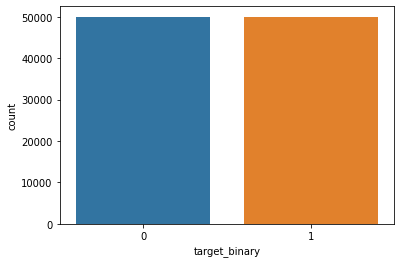

In [9]:
sns.countplot(data=df, x='target_binary')

# Perfect!

<p style="font-size: 16px">
    Let's look at some examples of positive and negative comments, just to get familiar with the syntax.
    </p>

In [10]:
positive_for_display = df[df['target_binary'] == 0].sample(10, random_state=101)

negative_for_display = df[df['target_binary'] == 1].sample(10, random_state=102)

for idx, col in positive_for_display.iterrows():
    print(f'{col["comment_text"]}    | "Not Toxic"\n')
    
for idx, col in negative_for_display.iterrows():
    print(f'{col["comment_text"]}    | "Toxic"\n')

You are forgetting that those foreigners (most of them) become Permanent residents within a few years.   Having said that majority of buyers less than 2 millions are Permanent residents (some of whom lend their name for the foreigners).   

It is complicated and messy.    | "Not Toxic"

America is becoming exactly what you see it becoming.    | "Not Toxic"

Muckamuck - so Obama does the same thing and you support him.  Gulp as you would say    | "Not Toxic"

Open your mind too and you'll see the harmless CD seller had an identical previous incident where (again) he had a pistin in his belt.  While the actual events will play out and yes, the cops could have overreacted, you have to acknowledge that thugs with guns breaking tbe law by intimidating law abiding citizens on a sidewalk are hardly a victim in the truest sense.  It takes two to Tango and if you're breaking tbe law already and have a gun on you the liklihood of a bad outcome is obvious.    | "Not Toxic"

What insults about mon

<h1 style="font-size: 25px">Let's start simple:
    </h1>

<p style="font-size: 16px">
    For the initial stages, let's look at character, word and sentence counts, and also at their average length. We will look at this number overall and also aggregated by "positive" and "negative" scores. Here we want to check if the numbers differ if we look at the general statistics grouped by the target value.
    </p>

<h1>
    Character, Word and Sentence counts:
    </h1>

<p style="font-size: 16px">
    The first thing is to get the overall length of each sequence by simply counting the amount of characters in the sequence, spaces included.
    </p>

In [11]:
df['string_length'] = df['comment_text'].map(lambda x: len(x))
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comment_text,target,target_binary,string_length
1340159,i doubt he meant to hert ur feelings DJ,0.000000,0,39
939303,Excellent response!,0.166667,0,19
1270024,Stephen Harper by contrast had the personality...,0.000000,0,259
290884,I can't be completely certain. But the prior ...,0.500000,1,181
1494173,"klastri> Just who are the ""racist imbeciles"" ...",0.723684,1,75


In [12]:
df['word_count'] = df['comment_text'].map(lambda x: len(x.split()))
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comment_text,target,target_binary,string_length,word_count
1340159,i doubt he meant to hert ur feelings DJ,0.000000,0,39,9
939303,Excellent response!,0.166667,0,19,2
1270024,Stephen Harper by contrast had the personality...,0.000000,0,259,48
290884,I can't be completely certain. But the prior ...,0.500000,1,181,32
1494173,"klastri> Just who are the ""racist imbeciles"" ...",0.723684,1,75,12


In [13]:
df['sentence_length'] = df['comment_text'].map(lambda x: len(sent_tokenize(x)))
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comment_text,target,target_binary,string_length,word_count,sentence_length
1340159,i doubt he meant to hert ur feelings DJ,0.000000,0,39,9,1
939303,Excellent response!,0.166667,0,19,2,1
1270024,Stephen Harper by contrast had the personality...,0.000000,0,259,48,2
290884,I can't be completely certain. But the prior ...,0.500000,1,181,32,3
1494173,"klastri> Just who are the ""racist imbeciles"" ...",0.723684,1,75,12,2


<h2>
    Aggregated metrics and visualizations of the data!
    </h2>

<p style="font-size: 16px">
    Let's go through some of the more typical data aggregations and visualizations. The simplest one of all, let's compute the means and medians for the word string, word and sentence counts using the .agg method on the pandas DataFrame.
    </p>

In [14]:
df.groupby('target_binary')[['string_length', 'word_count', 'sentence_length']].agg(['mean', 'median'])

string_length        word_count        sentence_length       
                       mean median       mean median            mean median
target_binary                                                              
0                 299.95138  204.0   51.70232   35.0         3.50450    3.0
1                 276.84124  194.0   48.27550   34.0         3.57742    3.0

### 

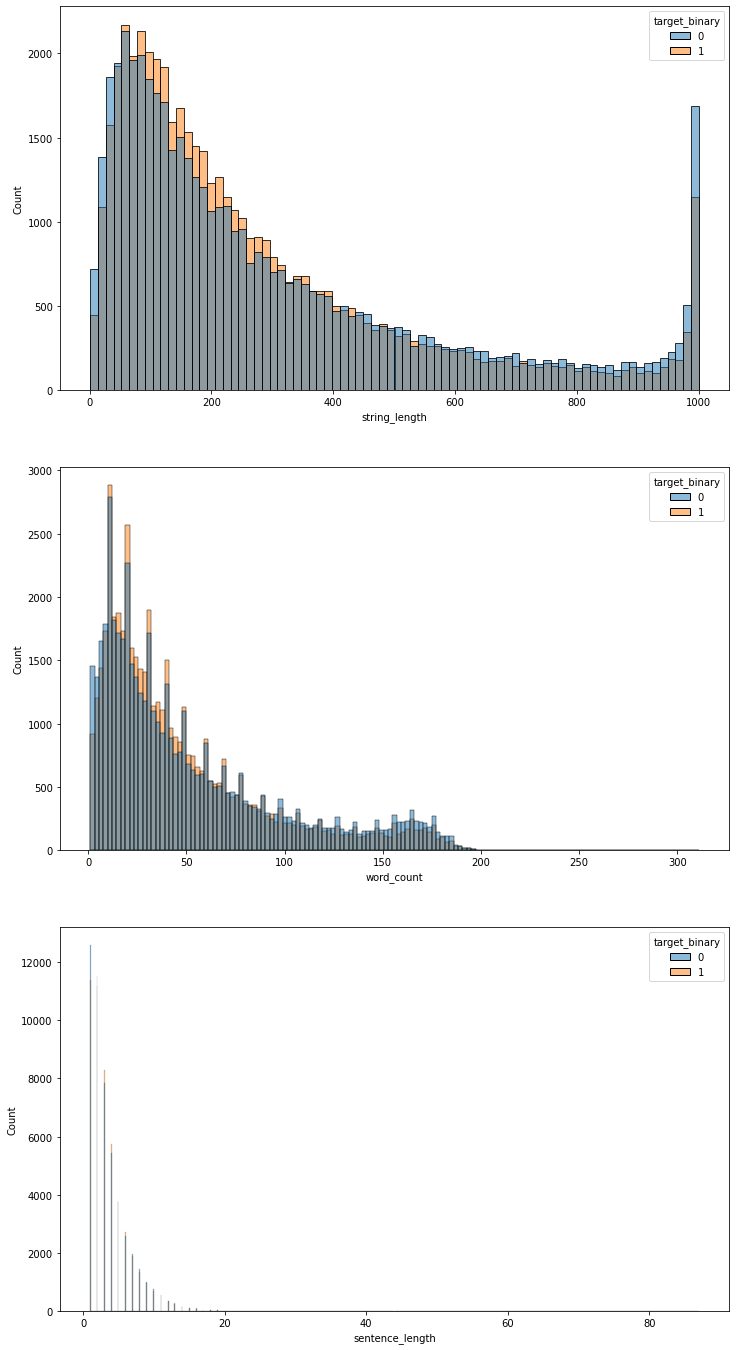

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(12, 24))

for idx, column in enumerate(['string_length', 'word_count', 'sentence_length']):
    sns.histplot(data=df, x=column, hue='target_binary', ax=ax[idx])

<p style="font-size: 16px">
    There doesn't seem to be a very strong connection between any of the extra features we created and the target variable we are trying to predict. Let's keep digging.
    </p>

<h1>
    Cleaning up the strings
    </h1>

<p style="font-size: 16px">
    One problem we will find is special characters. Special characters are often annoying to deal with because they don't add context, but they add irrelevant information. Characters like "@XXXX" for mentions, or special string configurations like links are complicated to deal with because they are unique and so the model probably won't be able to capture it's relevance.
    </p>

<p style="font-size: 16px">
    Other special characters are simply removed because they don't provide relevant information. Think of characters like "&", "/" or similar. At the end of this process, we also want to remove all possible whitespaces repeated in the string. We do so because when we delete some of the components we may leave some extra spaces behind, and they need to be cleared.
    </p>

In [16]:
def remove_links(text):
  # Use a regular expression to search for links in the text
  links = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)

  # Iterate over the links and remove them from the text
  for link in links:
        text = text.replace(link, '')
        
  # Return the modified text
  return text

string_link1 = "Welcome to http://www.xyz.com or http://webcloud.net"
string_link2 = "Welcome to secure xyz https://www.xyz.com for your comfort"

print(remove_links(string_link1))
print(remove_links(string_link2))

Welcome to  or 
Welcome to secure xyz  for your comfort


In [17]:
def remove_handles_and_mentions(string: str) -> str:
    """Function that removes mentions with the typical "@xyz" format from the string you pass and
    replaces it with a ''.
    
    :param string: String that may contain mentions in the specified format.
    :type string: str
    :return: String with removed mentions.
    :rtype: str
    
    Examples:
        >>> remove_special_characters("Hello @Artemis1, welcome to the Moon")
        'Hello , welcome to the Moon'
        >>> remove_special_characters("Hello World, developed by @xyz")
        'Hello World, developed by '
    """
    # Use a regular expression to search for mentions in the text
    mentions = re.findall(r'@\w+', string)

    # Iterate over the mentions and remove them from the text
    for mention in mentions:
        string = string.replace(mention, '')

    return string

# Test the function
text = "Hey @user1, check out this tweet!"
print(remove_handles_and_mentions(text))

Hey , check out this tweet!


In [18]:
def remove_hashtag(string: str) -> str:
    """Function that removes only the hashtags (#) found in the string. This is done separately to
    keep the special tokens available once we finish with the preprocessing.
    
    :param string: 
    :type string:
    :return:
    :rtype:
    """
    special_characters = re.compile(r'#+')

    # Replace any special characters with an empty string
    return special_characters.sub(' ', string)

test_hash = 'Comida gratis #rata#comida#joooder #hola'
remove_hashtag(test_hash)

'Comida gratis  rata comida joooder  hola'

In [19]:
def remove_special_characters(string: str) -> str:
    """Function that gets a string and returns the same string without special characters. 
    Note, the only characters that are kept are exclamation and question marks and hashtags.
    
    :param string: The string to remove special characters from.
    :type string:  str
    :return: The string with special characters removed.
    :rtype: str 

    Examples:
        >>> remove_special_characters("Hello, World&")
        'Hello World'
        >>> remove_special_characters("Hello,$ World")
        'Hello World'
    """
    special_characters = re.compile(r'[^A-Za-z0-9 \!\?#]+')

    # Replace any special characters with an empty string
    return special_characters.sub('', string)

# Test the function
string = "This is a test string with #$% special characters!?"
print(remove_special_characters(string))

This is a test string with # special characters!?


In [20]:
def remove_extra_whitespaces(string: str) -> str:
    """Remove extra whitespaces from a string.

    :param string: The string to remove extra whitespaces from.
    :type string: str
    :return: The string with extra whitespaces removed.
    :rtype: str

    Examples:
        >>> remove_extra_whitespaces("Hello, World!  ")
        'Hello, World!'
        >>> remove_extra_whitespaces("  Hello,     World!  ")
        'Hello, World!'
    """
    # Use a regular expression to search for multiple consecutive whitespace characters
    extra_whitespaces = re.compile(r'\s+')

    # Replace any extra whitespaces with a single space
    return extra_whitespaces.sub(' ', string).strip()

remove_extra_whitespaces('Hola   Mundo      mundial')

'Hola Mundo mundial'

<h1>
    String preprocessing
    </h1>

<p style="font-size: 16px">
    First, let's build a preprocessing pipeline for strings. We haven't needed this until now because counting words, characters or sentences does not require to preprocess the text much. You can argue that counting characters does, because the length may change if there are a lot of characters involved, but in a general sense, for word counts and sentence counts, you don't care if the word ends with a "!" or not.
    </p>

<p style="font-size: 16px">
    But now, we need to count how many times a word appear in the dataset, so it does matter if the word is "cloud" or "cloud!" because our process will count them as different words. We will use the nltk word_tokenize function to convert the text into a list of "tokens" (words for simplicity).
    </p>

<p style="font-size: 16px">
    Also, if you have worked with NLP before, you will know that there is another problem known as stop-words. Stop-words are commonly used words the don't provide meaning to the text. Words like: "the", "is", "and" are words that don't matter if you want to know if a text is toxic or not.
    </p>

<p style="font-size: 16px">
    And so, the general approach to deal with them is by removing them from the corpus. Stop-words have another drawback which is that they tend to be the most frequent words in texts, so you models will focus on the words that are less meaningful to the text.
    </p>

In [21]:
def remove_stopwords(text: str) -> list:
    """Function to remove stopwords from "text" string and returns the tokenized form of the 
    text in list format. So, words are converted to tokens and put into a list, only if they are 
    not a stopword.
    
    :param text: String to pass to the function. This acts as a the text you want to tokenize 
    and remove stopwords
    :type text: str
    :return: List of tokens without english stopwords.
    :rtype: list
    """
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    return " ".join(filtered_words)

<h2>
    Removing percentages, dates and general numbers:
    </h2>

<p style="font-size: 16px">
    Another interesting token to take into account is numbers. For NLP in general, we may be interested in removing all possible numbers from the data. But in most cases, we are interested in getting some kind of indication of the type of numebr it is. A very simple one is percentages or dates.
    </p>

<p style="font-size: 16px">
    We want to remove the number itself because every number in our dataset may be different and so if we end up using a BOW or TF-IDF vectorization method, we will get a higher dimensional space due to every new number being a new "column". This is not practical, but if we wanted, we could keep the number as a special token that captures the purpose that number serves.
    </p>

<p style="font-size: 16px">
    We will use 3 special tokens: #PERCENT, #DATE and #GENERALNUM and substitute each appearence of a number for one of these. The #GENERALNUM being a one-size-fits-all that is used for any number that doesn't fall into the other two categories.
    </p>

In [22]:
def substitute_percentages(string: str, token: str = '#PERCENT') -> str:
    """Substitute all percentages in a string for the token "#PERCENT" or the token you choose.

    :param string: The string to modify.
    :type string: str
    :param token: Token that will substitute the numbers, defaults to '#PERCENT'
    :type token: str, optional
    :return: The string with the percentages substituted by the #PERCENT token.
    :rtype: str

    Examples:
        >>> substitute_percentages("50.1% of the students passed the exam.")
        '#PERCENT of the students passed the exam.'
        >>> substitute_percentages("The success rate was 75.5%.")
        'The success rate was #PERCENT.'
    """
    # Use a regular expression to search for percentages in the string
    percentages = re.compile(r'\d+(\.\d+)? ?%')

    # Replace any percentages with the "#PERCENT" token
    return percentages.sub(token, string)

In [23]:
percent_text = 'This is 50.1% cheaper'
substitute_percentages(percent_text)

'This is #PERCENT cheaper'

In [24]:
def substitute_dates(string: str, token: str = '#DATE') -> str:
    """Substitute all dates in a string for the token "#DATE".

    :param string: The string to modify.
    :type string: str
    :param token: Token that will substitute the numbers, defaults to '#DATE'
    :type token: str, optional
    :return: The modified string.
    :rtype: str

    Examples:
        >>> substitute_dates("The meeting is scheduled for January 1, 2021.")
        'The meeting is scheduled for #DATE.'
        >>> substitute_dates("Today is December 31, 2020.")
        'Today is #DATE.'
        >>> substitute_dates("The meeting is scheduled for 01-01-2021.")
        'The meeting is scheduled for #DATE.'
        >>> substitute_dates("Today is 12-31-2020.")
        'Today is #DATE.'
    """
    # Use a regular expression to search for written dates in the string
#     dates_1 = re.compile(r'\b(?:(?:[Jj]an(?:uary)?|[Ff]eb(?:ruary)?|[Mm]ar(?:ch)|[Aa]pr(?:il)|[Mm]ay|[Jj]un(?:e)|[Jj]ul(?:y)|[Aa]ug(?:ust)|[Ss]ep(?:tember)|[Oo]ct(?:ober)|[Nn]ov(?:ember)|[Dd]ec(?:ember)?) \d+(?:st|nd|rd|th)?, \d{4}|today|tomorrow|next\s\w+|\w+st|\w+nd|\w+rd|\w+th|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|eleventh|twelfth)\b')
    dates_2 = re.compile(r'\b\d{2}[- _\/]\d{2}[- _\/]\d{2,4}\b')
    
    # Replace any dates with the "#DATE" token
#     string = dates_1.sub(token, string)
    string = dates_2.sub(token, string)
    
    return string

test = 'This happened on 21-02-2021' #'This happened on january 1st, 2021' not included
substitute_dates(test)

'This happened on #DATE'

In [25]:
def substitute_numbers(string: str, token: str = '#GENERALNUM') -> str:
    """Function that substitutes all numbers (including decimal numbers) in a string for the token 
    you specify.
    
    :param string: String on which you want to remove numbers
    :type string: str
    :param token: Token that will substitute the numbers, defaults to '#GENERALNUM'
    :type token: str, optional
    :return: Returns the string with the numbers substituted by the token you pass.
    :rtype: str
    
    Examples:
        >>> substitute_numbers("There are 2 dogs and 3.5 cats.", '#THIS-IS-A-NUMBER')
        'There are #THIS-IS-A-NUMBER dogs and #THIS-IS-A-NUMBER cats.'
    """
    # Use a regular expression to match all numbers (including decimals)
    pattern = r'\d+(\.\d+)?'
    
    return re.sub(pattern, token + ' ', string)

In [26]:
text_ex = "There are 2 dogs and 3.5 cats."
print(substitute_numbers(text_ex, '#GENERALNUM'))

There are #GENERALNUM  dogs and #GENERALNUM  cats.


<h2>
    Building the number preprocessing sub-pipeline:
    </h2>

<p style="font-size: 16px">
    Preprocessing the numbers is something that needs to be done all at once. You define which of this functions you want to use and apply all this functions one after the other. So this is what we are doing with the number preprocessing pipeline.
    </p>

In [27]:
def number_preprocessing_pipeline(
    string: str, percentage_token: str = ' #PERCENT ', date_token: str = ' #DATE ', 
    general_num_token: str = ' #GENERALNUM '
) -> str:
    """Function that goes over the entire string pipeline for dealing with numbers for a single string.

    :param string: String you want to preprocess (it may have dates, percentages or numbers).
    :type string: str
    :param percentage_token: The token for when the process encounters a percentage, defaults to 
    '#PERCENT'
    :type percentage_token: str, optional
    :param date_token: The token for when the process encounters a date, defaults to '#DATE'
    :type date_token: str, optional
    :param general_num_token: The token for when the process encounters a number that is neither a date 
    nor a percentage, defaults to '#GENERALNUM'.
    :type general_num_token: str, optional
    :return: The postprocessed string.
    :rtype: str
    
    Examples:
        >>> number_preprocessing_pipeline("There are 2 dogs and 3.5 cats. And one 100% cat-dog", percentage_token="#PERCENT", date_token="#DATE", general_num_token="#GENERALNUM")
        'There are #GENERALNUM dogs and #GENERALNUM cats. And one #PERCENT cat-dog'
    """
    string = substitute_percentages(string, percentage_token)
    string = substitute_dates(string, date_token)
    string = substitute_numbers(string, general_num_token)
    
    return string

In [28]:
df['no_stopwords'] = df['comment_text'].map(remove_stopwords)
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comment_text,target,target_binary,string_length,word_count,sentence_length,no_stopwords
1340159,i doubt he meant to hert ur feelings DJ,0.000000,0,39,9,1,doubt meant hert ur feelings DJ
939303,Excellent response!,0.166667,0,19,2,1,Excellent response !
1270024,Stephen Harper by contrast had the personality...,0.000000,0,259,48,2,Stephen Harper contrast personality dial tone ...
290884,I can't be completely certain. But the prior ...,0.500000,1,181,32,3,ca n't completely certain . prior conversation...
1494173,"klastri> Just who are the ""racist imbeciles"" ...",0.723684,1,75,12,2,"klastri > `` racist imbeciles '' speak , anywa..."


In [29]:
df[df['no_stopwords'].str.contains('%')]

,comment_text,target,target_binary,string_length,word_count,sentence_length,no_stopwords
1074652,The problem is that despite of their relativel...,0.5,1,341,58,3,problem despite relatively small % population ...
1378549,"I don't know what you mean by the ""other half....",0.0,0,99,18,2,n't know mean `` half . '' Perhaps 're thinkin...
1648872,Blacks are more likely to be searched in the t...,0.5,1,987,160,8,Blacks likely searched traffic stops likely re...
1462584,It's the fact that we are being taxed 42.5% an...,0.2,0,995,171,7,'s fact taxed 42.5 % squeezed like sponge ever...
1468530,What's your source for that 70%/5 hr. statistic?,0.0,0,48,8,2,'s source 70 % /5 hr . statistic ?
...,...,...,...,...,...,...,...
1128810,Your knowledge of China must be very limited. ...,0.0,0,591,81,9,knowledge China must limited . dominant attitu...
1164161,I dislike generalizations. The TSX Income Tru...,0.0,0,296,55,4,dislike generalizations . TSX Income Trust Cap...
50480,"Sorry, it seems incredibly risky to put a clow...",0.8,1,250,48,2,"Sorry , seems incredibly risky put clown like ..."
647732,What the GOP has been tasked with from it's ub...,0.0,0,992,177,6,GOP tasked 's uber wealthy donors repeal taxes...


<h2>
    Full preprocessing pipeline:
    </h2>

<p style="font-size: 16px">
    With all these functions, we create a process that runs all these functions on top of each other to create the final results, which are the clean strings we want to feed our ML models once we need them.
    </p>

In [30]:
def text_preprocessing(
    text: str, percentage_token: str = ' #PERCENT ', date_token: str = ' #DATE ', 
    general_num_token: str = ' #GENERALNUM '
) -> str:
    """Function that does all the preprocessing needed to a string in order to get it up and running
    for basic ML tasks. This function removes links, hanldes and mentions,
    """
    text = remove_links(text.lower())
    text = remove_handles_and_mentions(text)
    text = remove_hashtag(text)
    text = remove_stopwords(text)
    text = number_preprocessing_pipeline(text, percentage_token, date_token, general_num_token)
    text = remove_special_characters(text)
    text = remove_extra_whitespaces(text)
    
    return text

test = "Hello! This is a string to test if links:   https://hashtag.com are correctly removed. The user    @dark_mike20   built this process,,, to make $$$$$ dollars   "
print(text_preprocessing(test))

test2 = "Hello! This is a 50% complete #string, isn't it? Go to http://go.com for more   data."
print(text_preprocessing(test2))

hello ! string test links correctly removed user built process make dollars
hello ! #PERCENT complete string nt ? go data


In [31]:
def preprocess_pipeline(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """Function that maps the "preprocess_pipeline" function to the DataFrame you pass on the column 
    you pass in the "column_name" argument.
    
    :param df: DataFrame that contains a row for each text instance you want to preprocess.
    :type df: pd.DataFrame
    :param column_name: Name of the column where the text can be found.
    :type column_name: str
    :return: A copy of the DataFrame with a new column called "preprocessed_text" where the preprocessed 
    text is.
    :rtype: pd.DataFrame
    """
    df_copy = df.copy()
    df_copy["preprocessed_text"] = df[column_name].map(text_preprocessing)
    
    return df_copy

In [32]:
df_test = preprocess_pipeline(df, 'comment_text')
df_test.head()

,comment_text,target,target_binary,string_length,word_count,sentence_length,no_stopwords,preprocessed_text
1340159,i doubt he meant to hert ur feelings DJ,0.000000,0,39,9,1,doubt meant hert ur feelings DJ,doubt meant hert ur feelings dj
939303,Excellent response!,0.166667,0,19,2,1,Excellent response !,excellent response !
1270024,Stephen Harper by contrast had the personality...,0.000000,0,259,48,2,Stephen Harper contrast personality dial tone ...,stephen harper contrast personality dial tone ...
290884,I can't be completely certain. But the prior ...,0.500000,1,181,32,3,ca n't completely certain . prior conversation...,ca nt completely certain prior conversation qu...
1494173,"klastri> Just who are the ""racist imbeciles"" ...",0.723684,1,75,12,2,"klastri > `` racist imbeciles '' speak , anywa...",klastri racist imbeciles speak anyway ? ? ? ?


In [33]:
df_test[df_test['no_stopwords'].str.contains('%')]

,comment_text,target,target_binary,string_length,word_count,sentence_length,no_stopwords,preprocessed_text
1074652,The problem is that despite of their relativel...,0.5,1,341,58,3,problem despite relatively small % population ...,problem despite relatively small population st...
1378549,"I don't know what you mean by the ""other half....",0.0,0,99,18,2,n't know mean `` half . '' Perhaps 're thinkin...,nt know mean half perhaps re thinking shrinkin...
1648872,Blacks are more likely to be searched in the t...,0.5,1,987,160,8,Blacks likely searched traffic stops likely re...,blacks likely searched traffic stops likely re...
1462584,It's the fact that we are being taxed 42.5% an...,0.2,0,995,171,7,'s fact taxed 42.5 % squeezed like sponge ever...,s fact taxed #PERCENT squeezed like sponge eve...
1468530,What's your source for that 70%/5 hr. statistic?,0.0,0,48,8,2,'s source 70 % /5 hr . statistic ?,s source #PERCENT #GENERALNUM hr statistic ?
...,...,...,...,...,...,...,...,...
1128810,Your knowledge of China must be very limited. ...,0.0,0,591,81,9,knowledge China must limited . dominant attitu...,knowledge china must limited dominant attitude...
1164161,I dislike generalizations. The TSX Income Tru...,0.0,0,296,55,4,dislike generalizations . TSX Income Trust Cap...,dislike generalizations tsx income trust cappe...
50480,"Sorry, it seems incredibly risky to put a clow...",0.8,1,250,48,2,"Sorry , seems incredibly risky put clown like ...",sorry seems incredibly risky put clown like tr...
647732,What the GOP has been tasked with from it's ub...,0.0,0,992,177,6,GOP tasked 's uber wealthy donors repeal taxes...,gop tasked s uber wealthy donors repeal taxes ...


<h1>
    Word frequency
    </h1>

<p style="font-size: 16px">
    Now we are going to discuss word frequency. This is a very important aspect of working with text data, mostly to get familiar with the data you are going to train your model on. Bear in mind that **word frequency != word cloud**, even though most times they are confused between each other. Words clouds are just one techinique to visualize word frequency.
    </p>

<p style="font-size: 16px">
    There are a lot of sources like [this one](https://getthematic.com/insights/word-clouds-harm-insights/) about why word clouds are not ideal for visualizing text data, because we as humans are not the best at gauging non-linear magnitudes, and so we are not able to gauge if one word is more frequent or less than another, if they have similar sizes.
    </p>

<p style="font-size: 16px">
    I will show how to build a word cloud at the end, but remember that the same can be expressed with a barplot and the visual is much cleanear and simpler to understand.
    </p>

<h2>
    Building the function that creates the vocabulary
    </h2>

<p style="font-size: 16px">
    Below we will build the function that creates the vocabulary and returns it in an easy-to-digest way, so that we an build our different visuals.
    </p>

In [34]:
def build_vocab(data: pd.DataFrame, column_name: str = 'preprocessed_text'):
    """Function that builds the vocabulary. The vocabulary is comprised of the unique words that appear 
    in your dataset. The function creates a DataFrame where you can easily access the word counts, and 
    also returns a tuple that contains the individual arrays in case you want to use them directly.

    :param data: DataFrame that contains the column on which you want to create your vocabulary.
    :type data: pd.DataFrame
    :param column_name: Name of the column from which you want to build your vocabulary, 
    defaults to 'preprocessed_text'.
    :type column_name: str, optional
    """
    text_array = data[column_name].values
    list_of_token_lists = list(map(lambda x: x.split(), text_array))
    repeated_vocab = np.concatenate(list_of_token_lists)
    
    token_array, counts_array = np.unique(repeated_vocab, return_counts=True)
    
    return pd.DataFrame({'vocabulary': token_array, 'counts': counts_array}), (token_array, counts_array)

In [35]:
def set_out_of_vocab_token(
    df: pd.DataFrame, vocab_column: str = 'vocabulary', counts_column: str = 'counts', 
    oov_token: str = '#OOV', vocab_threshold: int = 2
) -> pd.DataFrame:
    """Function that restricts the vocabulary dimension by imposing a minimum number of times the word
    has to appear in order to be considered as a single contribution. If not, it will be converted into 
    the special token you pass, which by default is "#OOV" (out-of-vocabulary).

    :param df: DataFrame that contains the column on which you have your vocabulary and word counts 
    stored.
    :type df: pd.DataFrame
    :param vocab_column: Name of the column where the words from the vocabulary can be found, 
    defaults to 'vocabulary'
    :type vocab_column: str, optional
    :param counts_column: Name of the column where the word-counts are found, defaults to 'counts'.
    :type counts_column: str, optional
    :param oov_token: Name of the token that you want to impose to those words that appear less 
    "vocab_threshold", defaults to '#OOV'.
    :type oov_token: str, optional
    :param vocab_threshold: Number of times a word must appear to be considered part of the vocabulary, 
    defaults to 2
    :type vocab_threshold: int, optional
    :return: Returns the same DataFrame with the smaller vocabulary.
    :rtype: pd.DataFrame
    """
    df_copy = df.copy()
    
    vocab = df_copy.loc[df_copy[counts_column] >= vocab_threshold, vocab_column].tolist()
    df_copy.loc[df_copy[counts_column] < vocab_threshold, vocab_column] = oov_token
    
    return (
        df_copy.groupby('vocabulary').sum().reset_index().sort_values(counts_column, ascending=False),
        vocab
    )

In [36]:
df_vocab, (vocab_words, vocab_counts) = build_vocab(df_test, 'preprocessed_text')

In [37]:
df_vocab.sort_values('counts', ascending=False)

,vocabulary,counts
4,?,44016
61884,s,41240
2,#GENERALNUM,38712
48998,nt,33247
0,!,28832
...,...,...
44050,meritocracyequality,1
9700,bwaaa,1
44054,merkal,1
44055,merkans,1


array([[<AxesSubplot:title={'center':'counts'}>]], dtype=object)

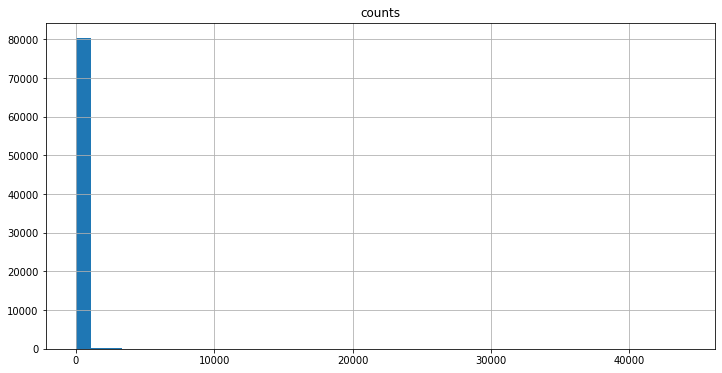

In [38]:
df_vocab.hist('counts', bins=40, figsize=(12, 6))

In [39]:
df_oov, vocab = set_out_of_vocab_token(df_vocab, 'vocabulary', 'counts', "#OOV", vocab_threshold=20)
df_oov['log_counts'] = df_oov['counts'].map(np.log)
df_oov

,vocabulary,counts,log_counts
3,#OOV,216704,12.286288
5,?,44016,10.692308
9090,s,41240,10.627164
2,#GENERALNUM,38712,10.563905
7097,nt,33247,10.411720
...,...,...,...
5445,intake,20,2.995732
2995,discriminating,20,2.995732
2447,crossings,20,2.995732
856,baptist,20,2.995732


array([[<AxesSubplot:title={'center':'log_counts'}>]], dtype=object)

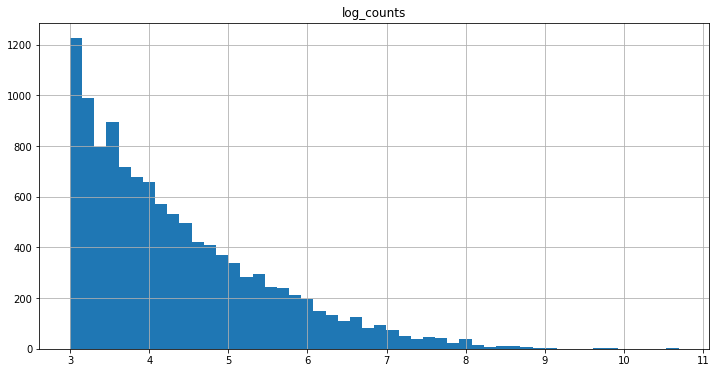

In [40]:
df_oov[df_oov['vocabulary'] != '#OOV'].hist('log_counts', bins=50, figsize=(12, 6))

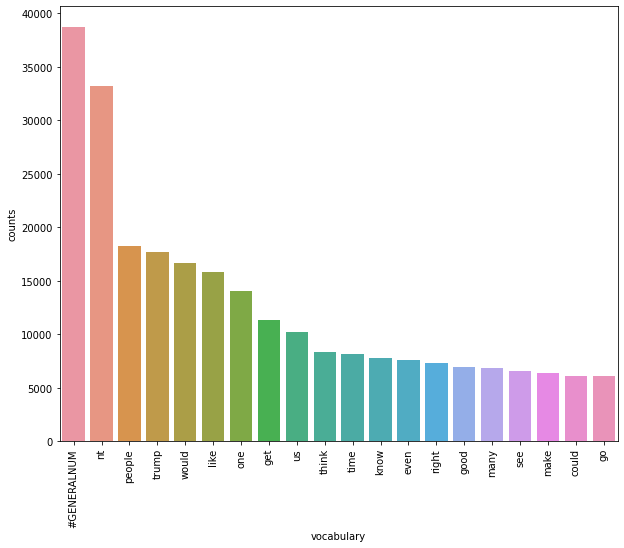

In [41]:
barplot_df = df_oov[~df_oov['vocabulary'].isin(['#OOV', 'DATE', 'GENERALNUM', '?', '!', 's'])]

plt.figure(figsize=(10, 8))
sns.barplot(data=barplot_df.head(20), x='vocabulary', y='counts');
plt.xticks(rotation=90);

In [42]:
vocab[:20]

['!',
 '#DATE',
 '#GENERALNUM',
 '#PERCENT',
 '?',
 'a',
 'aa',
 'aaa',
 'ab',
 'abandon',
 'abandoned',
 'abandoning',
 'abc',
 'abetted',
 'abhorrent',
 'abide',
 'abiding',
 'abilities',
 'ability',
 'abject']

In [43]:
def transform_vocab_single_line(text: str, vocab: Iterable, out_of_vocab_token: str = "#OOV") -> str:
    
#     tokenized_text = word_tokenize(text)
    tokenized_text = text.split()
    list_of_text_in_vocab = [
        word if word in vocab else out_of_vocab_token for word in tokenized_text
    ]
    
    return ' '.join(list_of_text_in_vocab)

testing = 'This is a text to test the transform_vocab_single_line function'
transform_vocab_single_line(testing, vocab, "#OOV")

'#OOV is a text to test the #OOV function'

In [44]:
def transform_vocab_entire_dataframe(
    df: pd.DataFrame, vocab: Iterable, out_of_vocab_token: str = "#OOV"
) -> pd.DataFrame:
    """
    """
    df_copy = df.copy()
    df_copy['text_with_vocab'] = (
        df_copy['preprocessed_text']
        .map(lambda x: transform_vocab_single_line(x, vocab, out_of_vocab_token))
    )
    
    return df_copy

In [45]:
df_final = transform_vocab_entire_dataframe(df_test, vocab, '#OOV')
df_final

,comment_text,target,target_binary,string_length,word_count,sentence_length,no_stopwords,preprocessed_text,text_with_vocab
1340159,i doubt he meant to hert ur feelings DJ,0.000000,0,39,9,1,doubt meant hert ur feelings DJ,doubt meant hert ur feelings dj,doubt meant #OOV ur feelings #OOV
939303,Excellent response!,0.166667,0,19,2,1,Excellent response !,excellent response !,excellent response !
1270024,Stephen Harper by contrast had the personality...,0.000000,0,259,48,2,Stephen Harper contrast personality dial tone ...,stephen harper contrast personality dial tone ...,stephen harper contrast personality #OOV tone ...
290884,I can't be completely certain. But the prior ...,0.500000,1,181,32,3,ca n't completely certain . prior conversation...,ca nt completely certain prior conversation qu...,ca nt completely certain prior conversation qu...
1494173,"klastri> Just who are the ""racist imbeciles"" ...",0.723684,1,75,12,2,"klastri > `` racist imbeciles '' speak , anywa...",klastri racist imbeciles speak anyway ? ? ? ?,klastri racist imbeciles speak anyway ? ? ? ?
...,...,...,...,...,...,...,...,...,...
506891,why will the investigation take 3 months. \n\...,0.732394,1,106,16,2,investigation take 3 months . frustrating Bozo...,investigation take #GENERALNUM months frustrat...,investigation take #GENERALNUM months frustrat...
512813,Let's see if we can now make a difference and ...,0.000000,0,317,56,4,Let 's see make difference stop giving away ev...,let s see make difference stop giving away eve...,let s see make difference stop giving away eve...
1011795,"Lyman, your post is disingenuous. Wallace was ...",0.400000,0,622,103,6,"Lyman , post disingenuous . Wallace end southe...",lyman post disingenuous wallace end southern d...,#OOV post disingenuous wallace end southern de...
1428936,Gosh...it MUST be his hair!,0.000000,0,27,5,1,Gosh ... MUST hair !,gosh must hair !,gosh must hair !


<h2>
    Full preprocessing pipeline:
    </h2>

<p style="font-size: 16px">
    Below we are building a pipeline to use on the test set, so that the test and train sets have the same preprocessing!
    </p>

In [46]:
def e2e_preprocessing(df: pd.DataFrame, vocab: typing.Callable) -> pd.DataFrame:
    """
    """
    df_copy = df.copy()
    df_copy = preprocess_pipeline(df_copy, 'comment_text')
    df_copy = transform_vocab_entire_dataframe(df_copy, vocab, '#OOV')
    
    return df_copy

<h1>
    Fitting a small model for classification:
    </h1>

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

df_mixed = df_final.sample(frac=1)
test_df  = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
test_df = e2e_preprocessing(test_df, vocab)

X_train = df_mixed['text_with_vocab']
X_test  = test_df['text_with_vocab']
y = df_mixed['target_binary']

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts  = count_vect.transform(X_test)

In [48]:
X_train[:5]

1728453    since three points address first sentence part...
232704     fact none #OOV pals beat demonstrates problem ...
802590     senator beyak lost ability personal voice prof...
923521     stated goals values organization include #OOV ...
687149     apparently rcmp lot free time cut reduce taxes...
Name: text_with_vocab, dtype: object

In [49]:
tfIdfVectorizer = TfidfVectorizer(use_idf=True)
tfIdf_train = tfIdfVectorizer.fit_transform(X_train)
tfIdf_test  = tfIdfVectorizer.transform(X_test)

df_idf = pd.DataFrame(tfIdf_train[1].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df_idf = df_idf.sort_values('TF-IDF', ascending=False)
df_idf.head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,TF-IDF
pals,0.504369
demonstrates,0.441303
beat,0.355533
none,0.327388
wing,0.320467
problem,0.255393
fact,0.252080
left,0.249720
oov,0.153128
aa,0.000000


In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [51]:
clf = MultinomialNB().fit(X_train_counts, y)
lr  = LogisticRegression(max_iter=1000).fit(X_train_counts, y)
rfc = RandomForestClassifier(n_estimators=501, n_jobs=-1).fit(X_train_counts, y)

clf_idf = MultinomialNB().fit(tfIdf_train, y)
lr_idf  = LogisticRegression(max_iter=1000).fit(tfIdf_train, y)
rfc_idf = RandomForestClassifier(n_estimators=501, n_jobs=-1).fit(tfIdf_train, y)

In [52]:
preds_nb     = clf.predict(X_train_counts)
preds_nb_idf = clf_idf.predict(tfIdf_train)

preds_lr     = lr.predict(X_train_counts)
preds_lr_idf = lr_idf.predict(tfIdf_train)

preds_rf     = rfc.predict(X_train_counts)
preds_rf_idf = rfc_idf.predict(tfIdf_train)

print('TRAIN PREDICTIONS:\n')

print('Word counts score NB:', accuracy_score(y, preds_nb))
print('TF-IDF score NB:', accuracy_score(y, preds_nb_idf))

print('Word counts score:', accuracy_score(y, preds_lr))
print('TF-IDF score:', accuracy_score(y, preds_lr_idf))

print('Word counts score NB:', accuracy_score(y, preds_rf))
print('TF-IDF score NB:', accuracy_score(y, preds_rf_idf))

TRAIN PREDICTIONS:

Word counts score NB: 0.79377
TF-IDF score NB: 0.81345
Word counts score: 0.89796
TF-IDF score: 0.87918
Word counts score NB: 0.99892
TF-IDF score NB: 0.99892


In [53]:
test = pd.DataFrame({'preprocessed_text': ['Fuck you you worthless scum', 'I kind of like your content']})

df_final_test = transform_vocab_entire_dataframe(test, vocab, '#OOV')
transf_test = count_vect.transform(df_final_test['text_with_vocab'])

test_preds = rfc.predict(transf_test)

In [54]:
test_preds

array([1, 0])

In [55]:
transf_test_idf = tfIdfVectorizer.transform(df_final_test['text_with_vocab'])

test_preds_idf = clf_idf.predict(transf_test)

In [56]:
test_preds_idf

array([1, 0])